<a href="https://colab.research.google.com/github/bkim9/Resume/blob/main/logmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please put AtriumNight.hdr to the file system to make it work

Based on "Adaptive Logarithmic Mapping For Displaying High Contrast Scenes" by  Drago etal.

link: https://resources.mpi-inf.mpg.de/tmo/logmap/
<br>
paper: https://resources.mpi-inf.mpg.de/tmo/logmap/logmap.pdf

In [ ]:
# Mount to my drive
from google.colab import drive
drive.mount('/content/drive')

# clone d2l github
!git clone https://github.com/d2l-ai/d2l-pytorch-colab.git

%cd ./d2l-pytorch-colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cloning into 'd2l-pytorch-colab'...
remote: Enumerating objects: 10698, done.
remote: Counting objects: 100% (10698/10698), done.
remote: Compressing objects: 100% (1944/1944), done.
remote: Total 10698 (delta 8600), reused 10681 (delta 8590), pack-reused 0
Receiving objects: 100% (10698/10698), 205.41 MiB | 21.21 MiB/s, done.
Resolving deltas: 100% (8600/8600), done.
Updating files: 100% (551/551), done.
/content/d2l-pytorch-colab/d2l-pytorch-colab


In [ ]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
import numpy as np

In [ ]:
import cv2
hdr_ori = cv2.imread('../../AtriumNight.hdr', cv2.IMREAD_UNCHANGED)

width: 760
height: 1016
np.sum(hdr_ori): 5447864.5


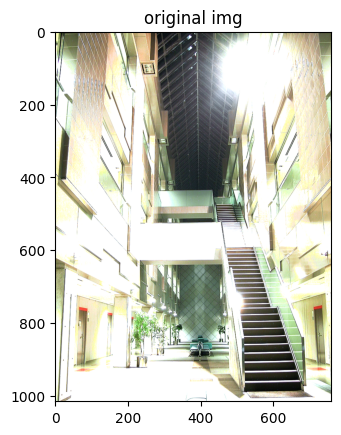

In [ ]:
np.max(hdr_ori)
img = hdr_ori[:, :, ::-1]
d2l.plt.figure()
d2l.plt.title('original img')
d2l.plt.imshow(img)
height, width, _ = hdr_ori.shape
print(f"width: {width}")
print(f"height: {height}")
print(f"np.sum(hdr_ori): {np.sum(hdr_ori)}")

In [ ]:
NATURAL_E = 2.7182718284
expo = 0.0        # Scene exposure
expo = pow(NATURAL_E, expo)
world_lum = 0.0   # Scene exposure
biasParam = 0.0 	# Bias Param
contParam = 0.0 	# Contrast improvement
gammaval = 1.0  	# Gamma value should use 2.2
ppm = False       # Save a ppm file
contParam = 0.0 	# Contrast improvement
km = 0.125		    # Kernel size multiplier
white = 1.0       # Max lum value of display - White 0.98
black = 0.02    	# Min lum value of display - Black
fast = False      # Use fast optimization
recgamma = False # Use Rec.709 gamma formula
center = False   # Use a center weighted world adaptation

test = np.array( [[0, 0, 0],
                     [0.265068, 0.67023428, 0.06409157],
                     [0.0241188, 0.1228178, 0.84442666]])
RGB2Yxy = np.array( [[0.5141364, 0.3238786, 0.16036376],
                     [0.265068, 0.67023428, 0.06409157],
                     [0.0241188, 0.1228178, 0.84442666]])
Yxy2RGB = np.array( [[2.5651, -1.1665, -0.3986],
						         [-1.0217, 1.9777, 0.0439],
						         [0.0753, -0.2543, 1.1892]])

In [ ]:
result = hdr_ori @ RGB2Yxy.T
Ys = result[:,:,1]
maximum = np.max(Ys)
minimum = np.min(Ys)
result_sum = np.sum(result)
log_sum = np.sum(np.log(2.3e-5 + Ys))
log_av = (log_sum / (width * height))

print(f"result_sum: {result_sum}")
print(f"log_sum: {log_sum}")
print(f"log_av: {log_av}")
print(f"maximum: {maximum}")
print(f"minimum: {minimum}")

W = result[:,:,0] + Ys + result[:,:,2]
exX = np.expand_dims(result[:,:,1],2)
exY = np.expand_dims(Ys/W,2)
exZ = np.expand_dims(result[:,:,1]/W,2)
xyz = np.concatenate([exX,exY,exZ],2)
print(f"sumxyz:{np.sum(xyz)}")
print(f"sumx:{np.sum(xyz[:,:,0])}")
print(f"sumy:{np.sum(xyz[:,:,1])}")
print(f"sumz:{np.sum(xyz[:,:,2])}")


result_sum: 5459523.57425982
log_sum: -73975.00033779666
log_av: -0.09580268381915233
maximum: 539.672679
minimum: 3.7246513813734056e-07
sumxyz:2320445.9308421044
sumx:1804371.1918251158
sumy:258037.369508494
sumz:258037.369508494


(1016, 760, 3) float64


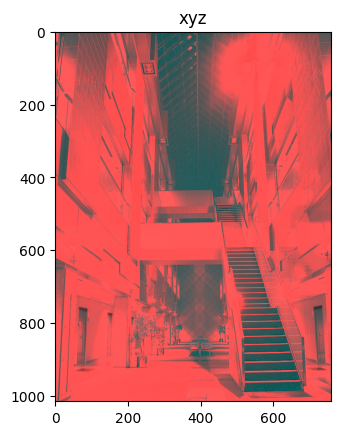

In [ ]:
print(xyz.shape, xyz.dtype)
d2l.plt.figure()
d2l.plt.title('xyz')
d2l.plt.imshow(xyz)

Bias parameter: 0.85 

world_lum: -0.09580268381915233 

av_lum: 0.908643608648182 

biasP: 0.23446531471358162 

contParam: 0.0 

Lmax: 593.932179639593 

divider: 2.7744674603721577 

expo: 1.0 

xyz[0,0,0]: 0.3498555069383111
0sum:1804371.1918251158
1sum:258037.369508494
2sum:258037.369508494
sumSir: 158212.21782292772 



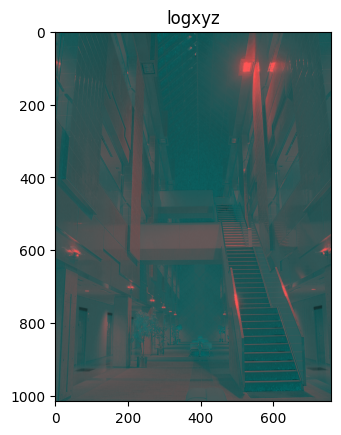

In [ ]:
# logmapping
  # Arbitrary Bias Parameter
LOG05 = -0.693147		# log(0.5)
NATURAL_E = 2.7182718284
world_lum = log_av
if (biasParam==0):
  biasParam = 0.85
print(f"Bias parameter: {biasParam} \n")
exp_adapt = 1 #pow(biasParam,5)
av_lum = pow(NATURAL_E,world_lum) / exp_adapt


print(f"world_lum: {world_lum} \n")
print(f"av_lum: {av_lum} \n")

biasP = np.log(biasParam)/LOG05
print(f"biasP: {biasP} \n")
if (contParam != 0):
  contP = 1/contParam
print(f"contParam: {contParam} \n")
Lmax = maximum/av_lum
print(f"Lmax: {Lmax} \n")
divider = np.log(Lmax+1)/np.log(10.0);
print(f"divider: {divider} \n")

print(f"expo: {expo} \n")
print(f"xyz[0,0,0]: {xyz[0,0,2]}")
print(f"0sum:{np.sum(xyz[:,:,0])}")
print(f"1sum:{np.sum(xyz[:,:,1])}")
print(f"2sum:{np.sum(xyz[:,:,2])}")
def bias (b, x):
  return pow (x, b)		# pow(x, log(bias)/log(0.5)
# Normal tone mapping of every pixel
  # inverse gamma function to enhance contrast
  # Not in paper
Sr = xyz[:,:,0]
if (contParam != 0):
  Sr = pow(Sr, contP)
Sr /= av_lum

if (expo != 1.0):
  Sr *= expo
interpol = np.log(2 + bias(biasP, Sr / Lmax) * 8)

Sr = np.log(Sr + 1)/interpol/divider
logxyz = xyz
logxyz[:,:,0] = Sr

print(f"sumSir: {np.sum(Sr)} \n")

d2l.plt.title('logxyz')
d2l.plt.imshow(logxyz)
d2l.plt.show()

In [ ]:
# Yxy_XYZ
EPSILON = 1e-06
xs = logxyz[:,:,1] + EPSILON
ys = logxyz[:,:,2] + EPSILON
X = xs * Sr / ys
Z = X / xs - X - Sr

exX = np.expand_dims(X,2)
exY = np.expand_dims(Sr,2)
exZ = np.expand_dims(Z,2)
xyz_after = np.concatenate([exX,exY,exZ],2)

# XYZ_rgb
rgb_done = xyz_after @ Yxy2RGB.T

In [ ]:
beforeScenesum = np.sum(logxyz)
print(f"beforeScenesum: {beforeScenesum}")
scenesum = np.sum(rgb_done)
print(f"scenesum: {scenesum}")
XYZsum = np.sum(xyz_after)
print(f"XYZsum: {XYZsum}")

beforeScenesum: 674286.9568399154
scenesum: 477939.84007219924
XYZsum: 476680.0845094123


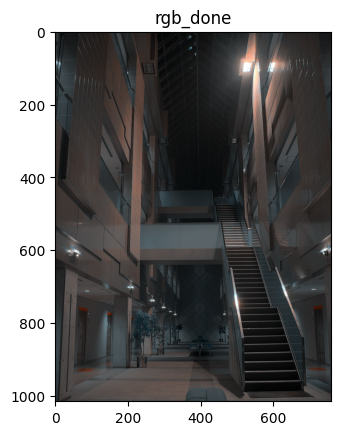

In [ ]:
d2l.plt.title('rgb_done')
d2l.plt.imshow(rgb_done[:, :, ::-1])
d2l.plt.show()

r g b


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

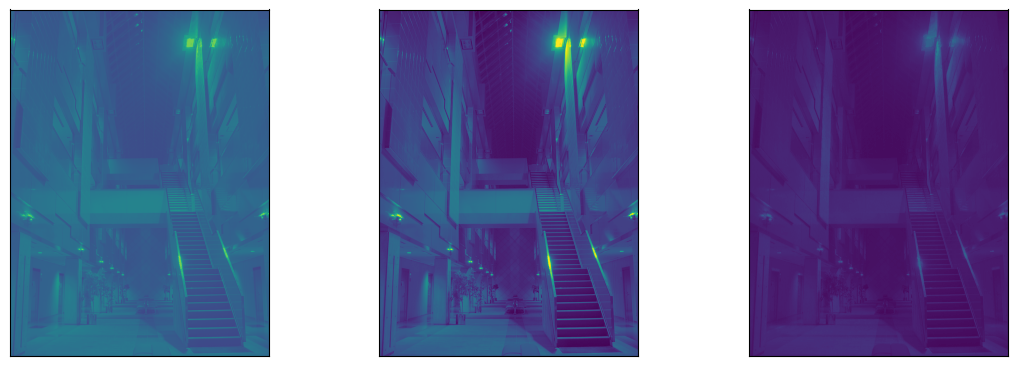

In [ ]:
r, g, b = cv2.split(rgb_done)
exR = np.expand_dims(r,2)
exG = np.expand_dims(g,2)
exB = np.expand_dims(b,2)
print("r g b")
d2l.show_images([exR,exG,exB], num_rows=1, num_cols=3, scale=4.5)

In [ ]:
def linearScale(input_img):
  min = np.min(input_img)
  max = np.max(input_img)
  return (input_img - min)/(max-min) + min